In [46]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from infodynamics import WindowedRollingDistance
from infodynamics.util import calc_vector_histogram

from src.dataset.util import read_jsonl, write_jsonl

In [3]:
INTERIM_PATH = '../data/interim/'
PROCESSED_PATH = '../data/processed/'

ds = read_jsonl(os.path.join(PROCESSED_PATH, 'publications_merged_concat.ndjson'))
meta = pd.read_csv(os.path.join(INTERIM_PATH, 'meta_publications_merged.csv'))

In [26]:
df = pd.DataFrame(ds)
df[['id', 'section']] = df['id'].str.split('_', expand=True) 
df.head()

,id,pub_date,text,embeddings,warning,section
0,p1,,Recent studies on mentalizing have shown that ...,"[-0.029172636568546295, 0.004647988826036453, ...",ok :),a
1,p1,,Introduction\nTheory of Mind is defined as the...,"[-0.029943235218524933, -0.007492228876799345,...",ok :),b
2,p2,2013-12-19,Some autistic children pass classic Theory of ...,"[-0.024920951575040817, -0.005315098911523819,...",ok :),a
3,p2,2013-12-19,Introduction\nOne of the most enduring puzzles...,[],"Error code: 400 - {'error': {'message': ""This ...",b
4,p3,,Fast Science is bad for scientists and bad for...,"[-0.015155889093875885, 0.01837518997490406, 0...",ok :),a


In [27]:
hot_fixes = {
    "Autism and Asperger Syndrome": 1991
}

meta['reconstructed_date'] = meta['reconstructed_date'].replace(hot_fixes)
meta['year'] = [funk.year for funk in pd.to_datetime(meta['reconstructed_date'], format='mixed')]
meta.head()

,id,title,date,doi,path,source,reconstructed_date,year
0,p1,"Knowing me, knowing you: Spontaneous use of me...",NaN,10.1177/1362361320951017,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2020,2020
1,p2,Autistic adolescents show atypical activation ...,2013-12-19,10.1016/j.neuropsychologia.2013.12.013,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2013-12-19,2013
2,p3,Fast Lane to Slow Science,NaN,10.1016/j.tics.2019.10.007,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2019,2019
3,p4,NaN,NaN,10.1098/rstb.2017.0361,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2018,2018
4,p5,Mapping Mentalising in the Brain,NaN,10.1007/978-3-030-51890-5_2,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2021,2021


In [30]:
df_ = df.merge(meta[['id', 'year', 'source']], on='id', how='left')
df_ = df_.sort_values('year')
df_.head()

,id,pub_date,text,embeddings,warning,section,year,source
320,p162,,,[],empty,a,1969,ocr
321,p162,,"\nJ. Oil Pye Pye, Vo. 10, 1963, p15 016, Perga...","[-0.02776145376265049, 0.018291359767317772, -...",ok :),b,1969,ocr
319,p161,,\n \n\n \n\nLasy Conf\n\n2»\n\nEMPHASIS AND ME...,"[-0.021632347255945206, 0.029784681275486946, ...",ok :),b,1969,ocr
318,p161,,,[],empty,a,1969,ocr
147,p74,,\nIt has recently been suggested that the unde...,"[-0.030155470594763756, 0.03465669974684715, 0...",ok :),b,1970,parsing


In [32]:
df_.query('warning == "empty"').groupby('section').size()

section
a    155
dtype: int64

In [33]:
df_.groupby('warning').size()

warning
Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 10082 tokens (10082 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}      1
Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 10091 tokens (10091 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}      1
Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 10099 tokens (10099 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}      1
Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you re

In [37]:
df_full_emb = df_.query('warning == "ok :)"')
df_full_emb

In [41]:
X = df_full_emb['embeddings'].tolist()
X = np.array(X)
X.shape

(312, 1536)

In [47]:
X_prob = [calc_vector_histogram(vect, bins=100) for vect in X]
X_prob = np.array(X_prob)
X_prob.shape

(312, 100)

In [64]:
wd = WindowedRollingDistance(
    measure='jensenshannon',
    window_size=5,
    estimate_error=True
)

signal = wd.fit_transform(X_prob)

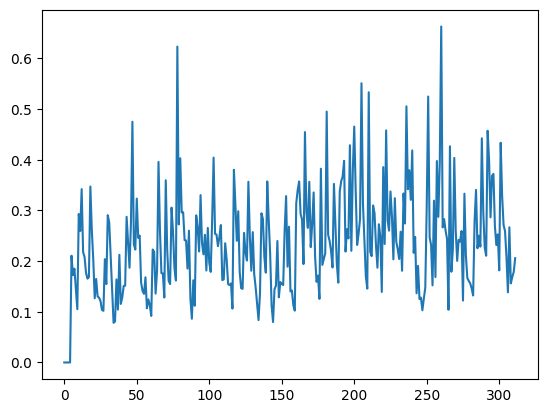

In [65]:
plt.plot(signal['N_hat'])

<Axes: >

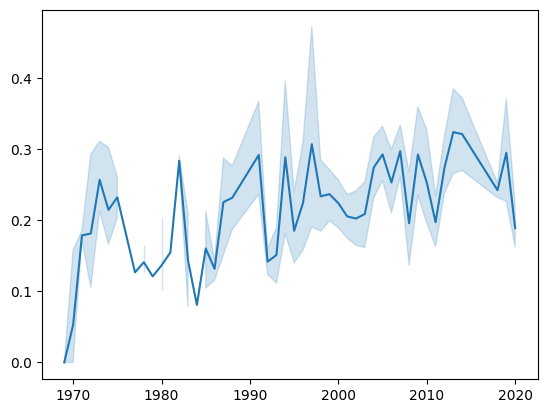

In [66]:
sns.lineplot(
    x=df_full_emb['year'].tolist(),
    y=signal['N_hat']
    )

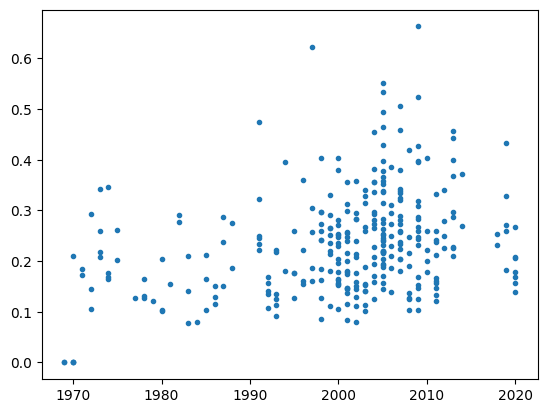

In [67]:
plt.plot(
    df_full_emb['year'].tolist(), signal['N_hat'], '.'
)